In [1]:
# Install the following:
# conda install -c conda-forge pymc3
# conda install -c conda-forge seaborn 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import preprocessing

Using NumPy C-API based implementation for BLAS functions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import the training and testing data

In [3]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


# Look at some simple linear regressions of the data

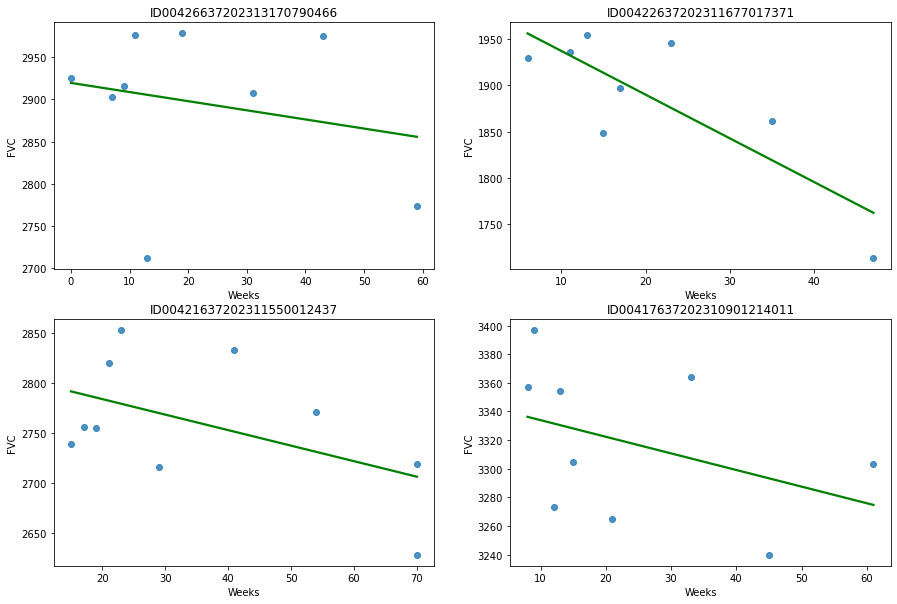

In [4]:
def plot_lin_reg(patient_id, ax, var='FVC'):
    data = train[train['Patient'] == patient_id]
    ax.set_title(patient_id)
    x = data['Weeks']
    y = data[var]
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'green'})
    

f, axes = plt.subplots(2, 2, figsize=(15, 10))

patient_ids = ['ID00426637202313170790466',
               'ID00422637202311677017371',
               'ID00421637202311550012437',
               'ID00417637202310901214011']

for ax, patient_id in zip(axes.reshape(-1), patient_ids):
    plot_lin_reg(patient_id, ax)

The charts above plot FVC versus time in weeks. For all six randomly chosen patients, there is a clear decline in FVC over time.

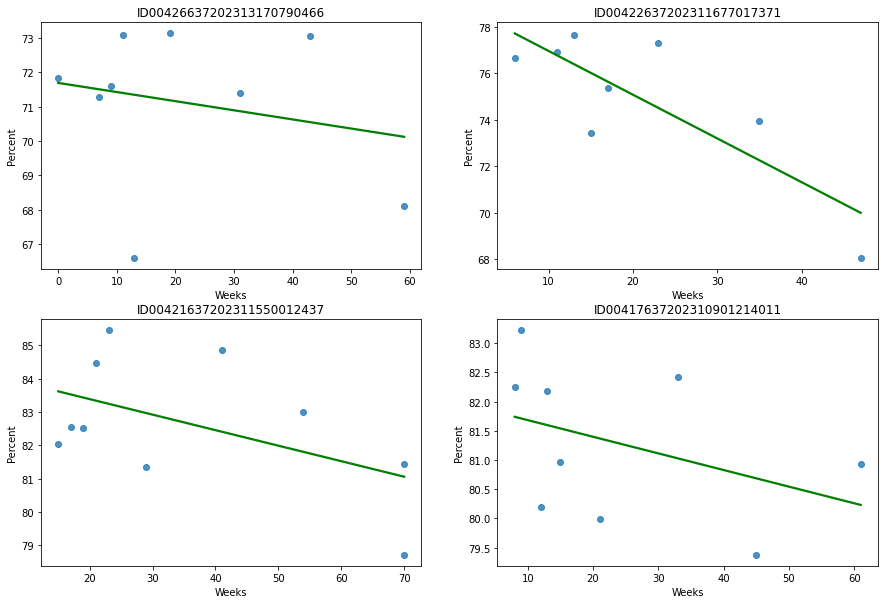

In [5]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, patient_id in zip(axes.reshape(-1), patient_ids):
    plot_lin_reg(patient_id, ax, var='Percent')

The charts above plot the data column 'percent' versus time. It is the same as the pervious chart because 'percent' and 'fvc' are proportional since 'percent' is calculated as 'fvc' divded by 'normal fvc for a person of similar characteristics'

# Data enhancement

In [6]:
# The purpose of this cell is to create classes of patients according to options 1, 2, and 3

# Option 1
def patient_class_sex_only(row):
    if row['Sex'] == 'Male':
        return 0
    else:
        return 1

# Option 2
def patient_class_smoking_status_only(row):
    if row['SmokingStatus'] == 'Currently smokes':
        return 0
    elif row['SmokingStatus'] == 'Ex-smoker':
        return 1
    elif row['SmokingStatus'] == 'Never smoked':
        return 2

# Option 3
#def patient_class_combo(row):
def patient_class(row):
    
    if row['SmokingStatus'] == 'Currently smokes':
        return 0 if row['Sex'] == 'Male' else 1
    elif row['SmokingStatus'] == 'Ex-smoker':
        return 2 if row['Sex'] == 'Male' else 3
    else:
        return 4 if row['Sex'] == 'Male' else 5

# Apply the classifications to the training and testing data
train['Class'] = train.apply(patient_class, axis=1)
test['Class'] = test.apply(patient_class, axis=1)

In [7]:
temp = train[['Patient', 'Weeks']].groupby('Patient').min().reset_index()
temp = pd.merge(temp, train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
temp = temp.groupby('Patient').mean().reset_index()
temp['Weeks'] = temp['Weeks'].astype(int)
temp['FVC'] = temp['FVC'].astype(int)
train = pd.merge(train, temp, how='left', on='Patient', suffixes=('', '_base'))

In [8]:
le = preprocessing.LabelEncoder()
train['PatientID'] = le.fit_transform(train['Patient'])

patients = train[['Patient', 'PatientID', 'Age', 'Class', 'Weeks_base', 'FVC_base']].drop_duplicates()
fvc_data = train[['Patient', 'PatientID', 'Weeks', 'FVC']]

In [9]:
# This is a table with the baseline week and baseline FVC for each patient
patients.head()

,Patient,PatientID,Age,Class,Weeks_base,FVC_base
0,ID00007637202177411956430,0,79,2,-4,2315
9,ID00009637202177434476278,1,69,2,8,3660
18,ID00010637202177584971671,2,60,2,0,3523
27,ID00011637202177653955184,3,72,2,6,3326
36,ID00012637202177665765362,4,65,4,33,3418


In [10]:
# This is a table of the observed FVC over time for each patient
fvc_data.head()

,Patient,PatientID,Weeks,FVC
0,ID00007637202177411956430,0,-4,2315
1,ID00007637202177411956430,0,5,2214
2,ID00007637202177411956430,0,7,2061
3,ID00007637202177411956430,0,9,2144
4,ID00007637202177411956430,0,11,2069


# Define model

In [11]:
FVC_b = patients['FVC_base'].values
w_b = patients['Weeks_base'].values
age = patients['Age'].values
patient_class = patients['Class'].values

t = fvc_data['Weeks'].values
FVC_obs = fvc_data['FVC'].values
patient_id = fvc_data['PatientID'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for Alpha
    beta_int = pm.Normal('beta_int', 0, sigma=100)
    sigma_int = pm.HalfNormal('sigma_int', 100)
    
    # Alpha
    mu_alpha = FVC_b + beta_int * w_b
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_int, 
                      shape=train['Patient'].nunique())
    
    # Hyperpriors for Beta
    sigma_s = pm.HalfNormal('sigma_s', 100)
    alpha_s = pm.Normal('alpha_s', 0, sigma=100)
    beta_cs = pm.Normal('beta_cs', 0, sigma=100, shape=6)
    
    # Beta
    mu_beta = alpha_s + age * beta_cs[patient_class]
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_s,
                     shape=train['Patient'].nunique())
    
    # Model variance
    sigma = pm.HalfNormal('sigma', 200)
    
    # Model estimate
    FVC_est = alpha[patient_id] + beta[patient_id] * t
    
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                          sigma=sigma, observed=FVC_obs)

# Fit the model

In [12]:
with hierarchical_model:
    trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, beta_cs, alpha_s, sigma_s, alpha, sigma_int, beta_int]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 91 seconds.


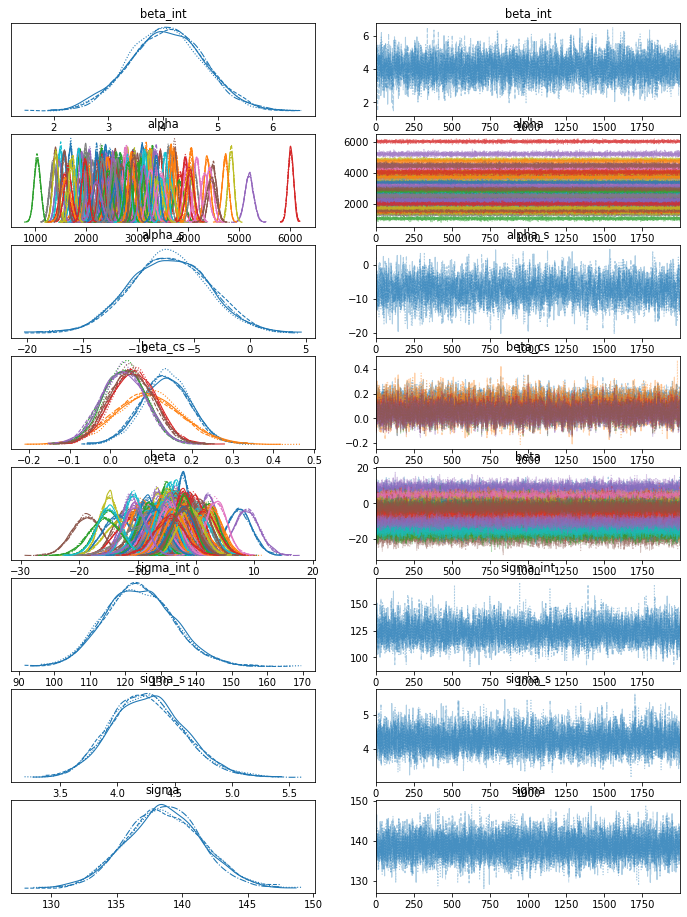

In [13]:
with hierarchical_model:
    pm.traceplot(trace);

In [14]:
# Fifth, prep test data
test = test.rename(columns={'FVC': 'FVC_base', 'Weeks': 'Weeks_base'})
test.head()

,Patient,Weeks_base,FVC_base,Percent,Age,Sex,SmokingStatus,Class
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,2
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,2
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,2
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,2
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,4


In [15]:
# prepare submission dataset
submission = []
for i, patient in enumerate(test['Patient'].unique()):
    df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = patient
    df['PatientID'] = i
    df['FVC'] = 0
    submission.append(df)
    
submission = pd.concat(submission).reset_index(drop=True)
submission.head()

,Patient,Weeks,FVC,PatientID
0,ID00419637202311204720264,-12,0,0
1,ID00419637202311204720264,-11,0,0
2,ID00419637202311204720264,-10,0,0
3,ID00419637202311204720264,-9,0,0
4,ID00419637202311204720264,-8,0,0


In [16]:
FVC_b = test['FVC_base'].values
w_b = test['Weeks_base'].values
age = test['Age'].values
patient_class = test['Class'].values
t = submission['Weeks'].values
patient_id = submission['PatientID'].values
            
with pm.Model() as new_model:
    # Hyperpriors for Alpha
    beta_int = pm.Normal('beta_int', 
                         trace['beta_int'].mean(), 
                         sigma=trace['beta_int'].std())
    sigma_int = pm.TruncatedNormal('sigma_int', 
                                   trace['sigma_int'].mean(),
                                   sigma=trace['sigma_int'].std(),
                                   lower=0)
    
    # Alpha
    mu_alpha = FVC_b + beta_int * w_b
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_int, 
                      shape=test['Patient'].nunique())
    
    # Hyperpriors for Beta
    sigma_s = pm.TruncatedNormal('sigma_s', 
                                 trace['sigma_s'].mean(),
                                 sigma=trace['sigma_s'].std(),
                                 lower=0)
    alpha_s = pm.Normal('alpha_s', 
                        trace['alpha_s'].mean(), 
                        sigma=trace['alpha_s'].std())
    cov = np.zeros((6, 6))
    np.fill_diagonal(cov, trace['beta_cs'].var(axis=0))
    beta_cs = pm.MvNormal('beta_cs',
                          mu=trace['beta_cs'].mean(axis=0),
                          cov=cov,
                          shape=6)
    
    # Beta
    mu_beta = alpha_s + age * beta_cs[patient_class]
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_s,
                     shape=test['Patient'].nunique())
    
    # Model variance
    sigma = pm.TruncatedNormal('sigma', 
                               trace['sigma'].mean(),
                               sigma=trace['sigma'].std(),
                               lower=0)
    
    FVC_est = pm.Deterministic('FVC_est', alpha[patient_id] + beta[patient_id] * t)

In [17]:
with new_model:
    trace2 = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, beta_cs, alpha_s, sigma_s, alpha, sigma_int, beta_int]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


In [18]:
# Generate predictions
preds = pd.DataFrame(data=trace2['FVC_est'].T)
submission = pd.merge(submission, preds, left_index=True, right_index=True)
submission['Patient_Week'] = submission['Patient'] + '_' + submission['Weeks'].astype(str)
submission = submission.drop(columns=['Patient', 'Weeks', 'FVC', 'PatientID'])

FVC = submission.iloc[:, :-1].mean(axis=1)
confidence = submission.iloc[:, :-1].std(axis=1)
submission['FVC'] = FVC
submission['Confidence'] = confidence
submission = submission[['Patient_Week', 'FVC', 'Confidence']]
submission.to_csv('submission.csv', index=False)
submission.head()

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3102.447718,150.027252
1,ID00419637202311204720264_-11,3097.684789,146.406893
2,ID00419637202311204720264_-10,3092.921860,143.025073
3,ID00419637202311204720264_-9,3088.158931,139.899092
4,ID00419637202311204720264_-8,3083.396002,137.046458
